In [1]:
import pandas as pd
from src.epl_proyection.etl import preprocessing
from src.epl_proyection.utils import ts_diagnostics
from src.epl_proyection.generate_analysis_table import generate_analysis
from src.epl_proyection.etl.preprocessing import generate_labor_data, run_preprocessing_pipeline
from src.epl_proyection.models.arimax.arimax_full_pipeline import predict_pea_arimax

df_before_preprocessing = generate_labor_data(path_national = 'data/anex-GEIH-feb2025.xlsx',
                            sheet_name_national='Total nacional',
                            path_sector='data/anex-GEIH-feb2025.xlsx',
                            sheet_name_sector='Ocupados TN_T13_rama',
                            path_formal_informal='data/anex-GEIHEISS-nov2024-ene2025.xlsx',
                            sheet_name_formal_informal='Grandes dominios ',
                            sector= ['Agricultura, ganadería, caza, silvicultura y pesca',
                                                                'Industrias manufactureras'])

df_preprocessed = run_preprocessing_pipeline(path_national = 'data/anex-GEIH-feb2025.xlsx',
                            sheet_name_national='Total nacional',
                            path_sector='data/anex-GEIH-feb2025.xlsx',
                            sheet_name_sector='Ocupados TN_T13_rama',
                            path_formal_informal='data/anex-GEIHEISS-nov2024-ene2025.xlsx',
                            sheet_name_formal_informal='Grandes dominios ',
                            sector= ['Agricultura, ganadería, caza, silvicultura y pesca',
                            'Industrias manufactureras'],
                            cols_to_lag=['Población en edad de trabajar (PET)', 'Población ocupada',
                            'Agricultura, ganadería, caza, silvicultura y pesca',
                            'Industrias manufactureras', 'Formal', 'Informal','Fuerza de trabajo  '])

df = generate_analysis.generate_analysis_table(path_national = 'data/anex-GEIH-feb2025.xlsx',
                            sheet_name_national='Total nacional',
                            path_sector='data/anex-GEIH-feb2025.xlsx',
                            sheet_name_sector='Ocupados TN_T13_rama',
                            path_formal_informal='data/anex-GEIHEISS-nov2024-ene2025.xlsx',
                            sheet_name_formal_informal='Grandes dominios ',
                            sector= ['Agricultura, ganadería, caza, silvicultura y pesca',
                            'Industrias manufactureras'],
                            cols_to_lag=['Población en edad de trabajar (PET)', 'Población ocupada',
                            'Agricultura, ganadería, caza, silvicultura y pesca',
                            'Industrias manufactureras', 'Formal', 'Informal','Fuerza de trabajo  '],
                            path_activity_formal='data/anex-GEIHEISS-nov2024-ene2025.xlsx',
                            sheet_name_activity_formal='Ramas de actividad CIIU 4 A.C')

[I 2025-04-29 16:18:35,230] A new study created in memory with name: no-name-03c55cb2-a1b5-40b7-9aa5-eb185b522cec
[I 2025-04-29 16:19:10,681] Trial 0 finished with value: 1.1637305668705602 and parameters: {'iterations': 929, 'learning_rate': 0.04682152522707586, 'depth': 10, 'l2_leaf_reg': 0.14857676934693073, 'bagging_temperature': 0.062462553698298895, 'random_strength': 0.7775341630201427}. Best is trial 0 with value: 1.1637305668705602.
[I 2025-04-29 16:19:12,328] Trial 1 finished with value: 1.4076420835578158 and parameters: {'iterations': 309, 'learning_rate': 0.06252779851935487, 'depth': 4, 'l2_leaf_reg': 2.418256947139439, 'bagging_temperature': 0.46863120818333437, 'random_strength': 0.11376425514127564}. Best is trial 0 with value: 1.1637305668705602.
[I 2025-04-29 16:19:30,828] Trial 2 finished with value: 1.5871294663403426 and parameters: {'iterations': 436, 'learning_rate': 0.08953826526744467, 'depth': 10, 'l2_leaf_reg': 0.05572675148596618, 'bagging_temperature': 0.9

0:	learn: 0.0162043	total: 40.3ms	remaining: 37.4s
1:	learn: 0.0157939	total: 63.7ms	remaining: 29.5s
2:	learn: 0.0153527	total: 105ms	remaining: 32.4s
3:	learn: 0.0150008	total: 144ms	remaining: 33.2s
4:	learn: 0.0146439	total: 172ms	remaining: 31.7s
5:	learn: 0.0143119	total: 202ms	remaining: 31s
6:	learn: 0.0139306	total: 230ms	remaining: 30.3s
7:	learn: 0.0135954	total: 255ms	remaining: 29.3s
8:	learn: 0.0132702	total: 284ms	remaining: 29.1s
9:	learn: 0.0129255	total: 331ms	remaining: 30.4s
10:	learn: 0.0126489	total: 366ms	remaining: 30.6s
11:	learn: 0.0123705	total: 400ms	remaining: 30.6s
12:	learn: 0.0121792	total: 410ms	remaining: 28.9s
13:	learn: 0.0118833	total: 457ms	remaining: 29.9s
14:	learn: 0.0115390	total: 503ms	remaining: 30.7s
15:	learn: 0.0113487	total: 538ms	remaining: 30.7s
16:	learn: 0.0111199	total: 568ms	remaining: 30.4s
17:	learn: 0.0109354	total: 602ms	remaining: 30.5s
18:	learn: 0.0107466	total: 630ms	remaining: 30.2s
19:	learn: 0.0105075	total: 662ms	remaini

In [4]:
df_alt = generate_labor_data(path_national = 'data/anex-GEIH-feb2025.xlsx',
                            sheet_name_national='Total nacional',
                            path_sector='data/anex-GEIH-feb2025.xlsx',
                            sheet_name_sector='Ocupados TN_T13_rama',
                            path_formal_informal='data/anex-GEIHEISS-nov2024-ene2025.xlsx',
                            sheet_name_formal_informal='Grandes dominios ',
                            sector= ['Agricultura, ganadería, caza, silvicultura y pesca',
                                                                'Industrias manufactureras'])

In [3]:
df_preprocessed = run_preprocessing_pipeline(path_national = 'data/anex-GEIH-feb2025.xlsx',
                            sheet_name_national='Total nacional',
                            path_sector='data/anex-GEIH-feb2025.xlsx',
                            sheet_name_sector='Ocupados TN_T13_rama',
                            path_formal_informal='data/anex-GEIHEISS-nov2024-ene2025.xlsx',
                            sheet_name_formal_informal='Grandes dominios ',
                            sector= ['Agricultura, ganadería, caza, silvicultura y pesca',
                            'Industrias manufactureras'],
                            cols_to_lag=['Población en edad de trabajar (PET)', 'Población ocupada',
                            'Agricultura, ganadería, caza, silvicultura y pesca',
                            'Industrias manufactureras', 'Formal', 'Informal','Fuerza de trabajo  '])

In [2]:
df = generate_analysis.generate_analysis_table(path_national = 'data/anex-GEIH-feb2025.xlsx',
                            sheet_name_national='Total nacional',
                            path_sector='data/anex-GEIH-feb2025.xlsx',
                            sheet_name_sector='Ocupados TN_T13_rama',
                            path_formal_informal='data/anex-GEIHEISS-nov2024-ene2025.xlsx',
                            sheet_name_formal_informal='Grandes dominios ',
                            sector= ['Agricultura, ganadería, caza, silvicultura y pesca',
                            'Industrias manufactureras'],
                            cols_to_lag=['Población en edad de trabajar (PET)', 'Población ocupada',
                            'Agricultura, ganadería, caza, silvicultura y pesca',
                            'Industrias manufactureras', 'Formal', 'Informal','Fuerza de trabajo  '],
                            path_activity_formal='data/anex-GEIHEISS-nov2024-ene2025.xlsx',
                            sheet_name_activity_formal='Ramas de actividad CIIU 4 A.C')

[I 2025-04-29 13:18:50,675] A new study created in memory with name: no-name-3021f237-ec58-4150-b548-e5ecec7c3f65
[I 2025-04-29 13:18:52,141] Trial 0 finished with value: 1.450676526691515 and parameters: {'iterations': 864, 'learning_rate': 0.26291459637450043, 'depth': 6, 'l2_leaf_reg': 0.25415583643092066, 'bagging_temperature': 0.303644976693204, 'random_strength': 0.9260559768889773}. Best is trial 0 with value: 1.450676526691515.
[I 2025-04-29 13:18:52,922] Trial 1 finished with value: 1.316867160792221 and parameters: {'iterations': 567, 'learning_rate': 0.011171083086649642, 'depth': 5, 'l2_leaf_reg': 4.296121792051857, 'bagging_temperature': 0.8620713577320477, 'random_strength': 0.0391951108959977}. Best is trial 1 with value: 1.316867160792221.
[I 2025-04-29 13:18:56,256] Trial 2 finished with value: 1.3994822218562766 and parameters: {'iterations': 670, 'learning_rate': 0.08920865153160656, 'depth': 8, 'l2_leaf_reg': 0.0070414853928343684, 'bagging_temperature': 0.841457094

0:	learn: 0.0165651	total: 955us	remaining: 288ms
1:	learn: 0.0164527	total: 1.43ms	remaining: 214ms
2:	learn: 0.0163440	total: 1.89ms	remaining: 189ms
3:	learn: 0.0162370	total: 2.47ms	remaining: 184ms
4:	learn: 0.0161319	total: 3.12ms	remaining: 186ms
5:	learn: 0.0160287	total: 3.68ms	remaining: 182ms
6:	learn: 0.0159547	total: 4.51ms	remaining: 190ms
7:	learn: 0.0158557	total: 5.55ms	remaining: 204ms
8:	learn: 0.0157533	total: 6.76ms	remaining: 220ms
9:	learn: 0.0156903	total: 7.68ms	remaining: 224ms
10:	learn: 0.0156116	total: 8.3ms	remaining: 220ms
11:	learn: 0.0155191	total: 9.81ms	remaining: 237ms
12:	learn: 0.0154243	total: 10.5ms	remaining: 233ms
13:	learn: 0.0153324	total: 11ms	remaining: 227ms
14:	learn: 0.0152511	total: 11.6ms	remaining: 223ms
15:	learn: 0.0151611	total: 12.5ms	remaining: 223ms
16:	learn: 0.0150717	total: 14.1ms	remaining: 237ms
17:	learn: 0.0150190	total: 14.8ms	remaining: 234ms
18:	learn: 0.0149390	total: 15.3ms	remaining: 228ms
19:	learn: 0.0148597	total

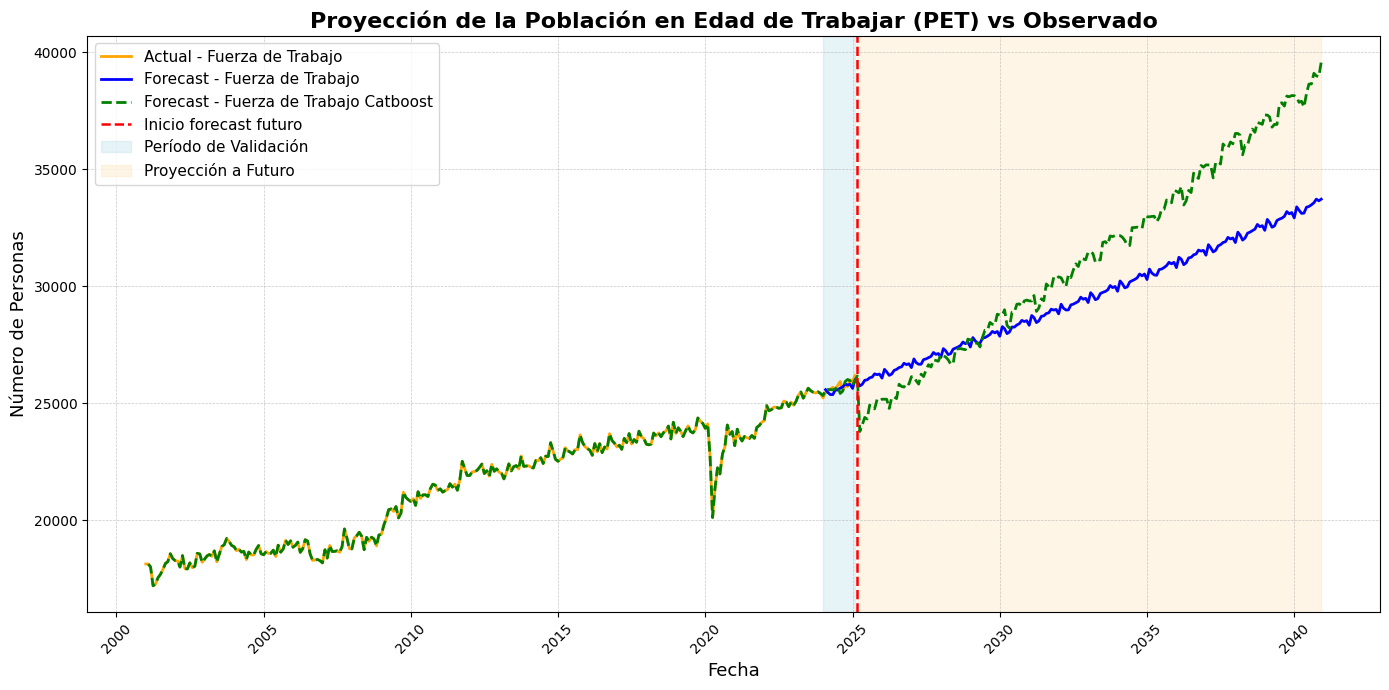

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# Serie real
plt.plot(df['ds'], df['Fuerza de trabajo  '], 
         label='Actual - Fuerza de Trabajo', color='orange', linewidth=2)

# Predicción
plt.plot(df['ds'], df['PredPETArimax'], 
         label='Forecast - Fuerza de Trabajo', color='blue',  linewidth=2)

# Predicción
plt.plot(df['ds'], df['PredPETCatboost'], 
         label='Forecast - Fuerza de Trabajo Catboost', color='green', linestyle='--', linewidth=2)

# Línea vertical indicando inicio de predicción futura
plt.axvline(x=pd.to_datetime("2025-03-01"), color='red', linestyle='--', linewidth=1.8, label='Inicio forecast futuro')

# Áreas sombreadas
plt.axvspan(pd.to_datetime('2024-01-01'), pd.to_datetime('2025-02-01'), 
            color='lightblue', alpha=0.3, label='Período de Validación')

plt.axvspan(pd.to_datetime('2025-03-01'), pd.to_datetime('2040-12-01'), 
            color='navajowhite', alpha=0.3, label='Proyección a Futuro')

# Títulos y etiquetas
plt.title('Proyección de la Población en Edad de Trabajar (PET) vs Observado', fontsize=16, fontweight='bold')
plt.xlabel('Fecha', fontsize=13)
plt.ylabel('Número de Personas', fontsize=13)

# Leyenda mejor posicionada
plt.legend(loc='upper left', fontsize=11)

# Mejorar el grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Mejoras estéticas
plt.xticks(rotation=45)
plt.tight_layout()

# Si quieres guardar
# plt.savefig('forecast_vs_actual_pet.png', dpi=300)

plt.show()


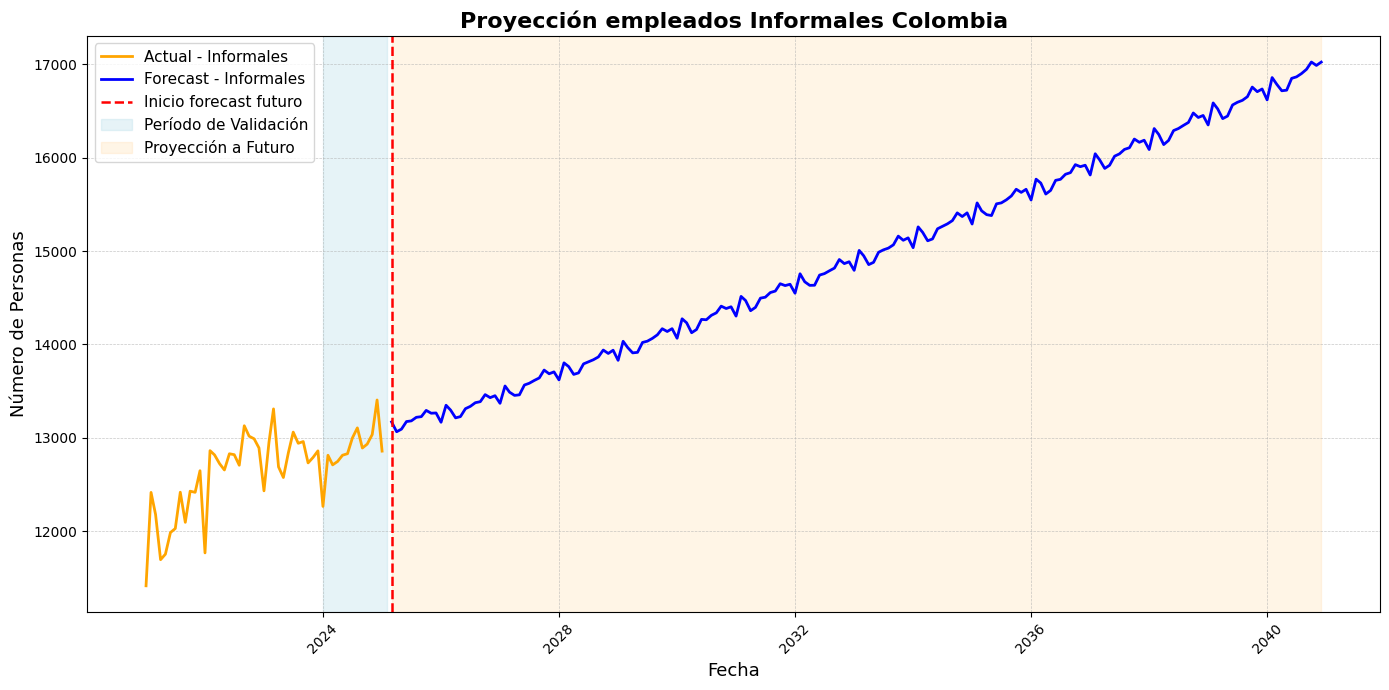

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# Serie real
plt.plot(df['ds'], df['Informal'], 
         label='Actual - Informales', color='orange', linewidth=2)

# Predicción
plt.plot(df['ds'], df['PredInformal'], 
         label='Forecast - Informales', color='blue',  linewidth=2)

# Línea vertical indicando inicio de predicción futura
plt.axvline(x=pd.to_datetime("2025-03-01"), color='red', linestyle='--', linewidth=1.8, label='Inicio forecast futuro')

# Áreas sombreadas
plt.axvspan(pd.to_datetime('2024-01-01'), pd.to_datetime('2025-02-01'), 
            color='lightblue', alpha=0.3, label='Período de Validación')

plt.axvspan(pd.to_datetime('2025-03-01'), pd.to_datetime('2040-12-01'), 
            color='navajowhite', alpha=0.3, label='Proyección a Futuro')

# Títulos y etiquetas
plt.title('Proyección empleados Informales Colombia', fontsize=16, fontweight='bold')
plt.xlabel('Fecha', fontsize=13)
plt.ylabel('Número de Personas', fontsize=13)

# Leyenda mejor posicionada
plt.legend(loc='upper left', fontsize=11)

# Mejorar el grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Mejoras estéticas
plt.xticks(rotation=45)
plt.tight_layout()

# Si quieres guardar
# plt.savefig('forecast_vs_actual_pet.png', dpi=300)

plt.show()

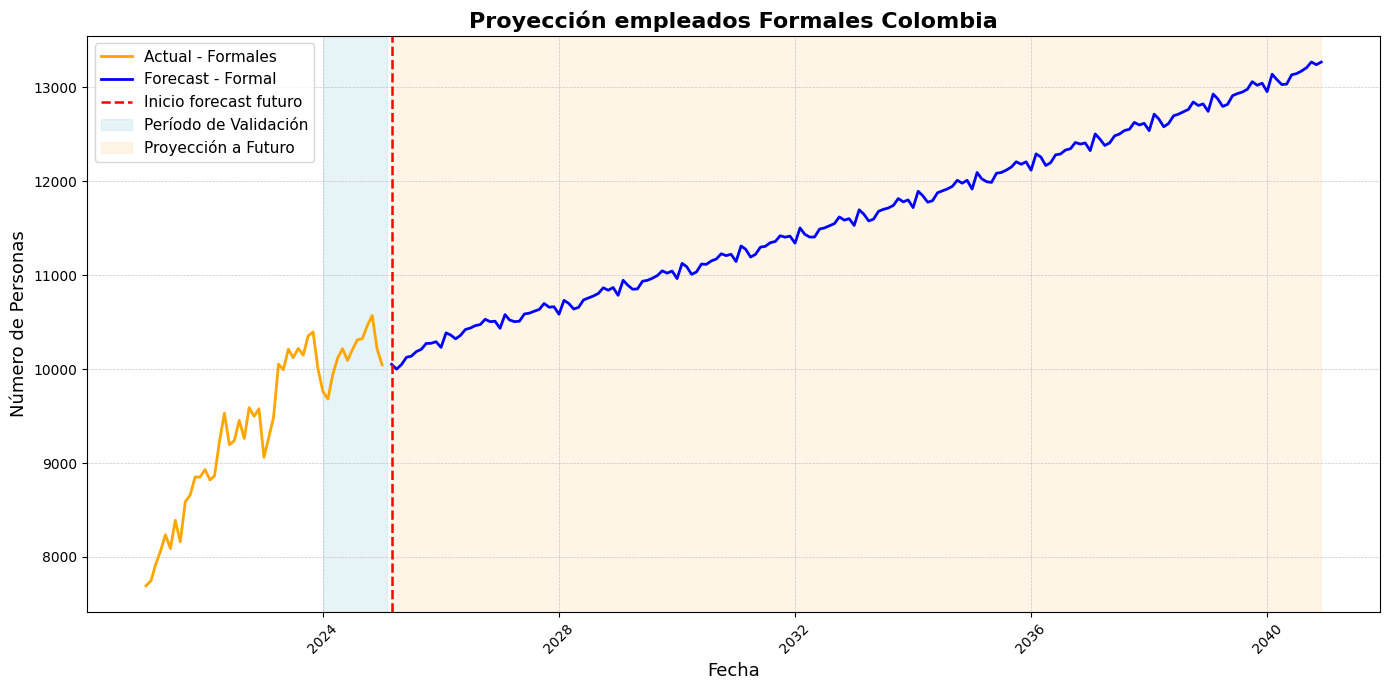

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# Serie real
plt.plot(df['ds'], df['Formal'], 
         label='Actual - Formales', color='orange', linewidth=2)

# Predicción
plt.plot(df['ds'], df['PredFormal'], 
         label='Forecast - Formal', color='blue',  linewidth=2)

# Línea vertical indicando inicio de predicción futura
plt.axvline(x=pd.to_datetime("2025-03-01"), color='red', linestyle='--', linewidth=1.8, label='Inicio forecast futuro')

# Áreas sombreadas
plt.axvspan(pd.to_datetime('2024-01-01'), pd.to_datetime('2025-02-01'), 
            color='lightblue', alpha=0.3, label='Período de Validación')

plt.axvspan(pd.to_datetime('2025-03-01'), pd.to_datetime('2040-12-01'), 
            color='navajowhite', alpha=0.3, label='Proyección a Futuro')

# Títulos y etiquetas
plt.title('Proyección empleados Formales Colombia', fontsize=16, fontweight='bold')
plt.xlabel('Fecha', fontsize=13)
plt.ylabel('Número de Personas', fontsize=13)

# Leyenda mejor posicionada
plt.legend(loc='upper left', fontsize=11)

# Mejorar el grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Mejoras estéticas
plt.xticks(rotation=45)
plt.tight_layout()

# Si quieres guardar
# plt.savefig('forecast_vs_actual_pet.png', dpi=300)

plt.show()

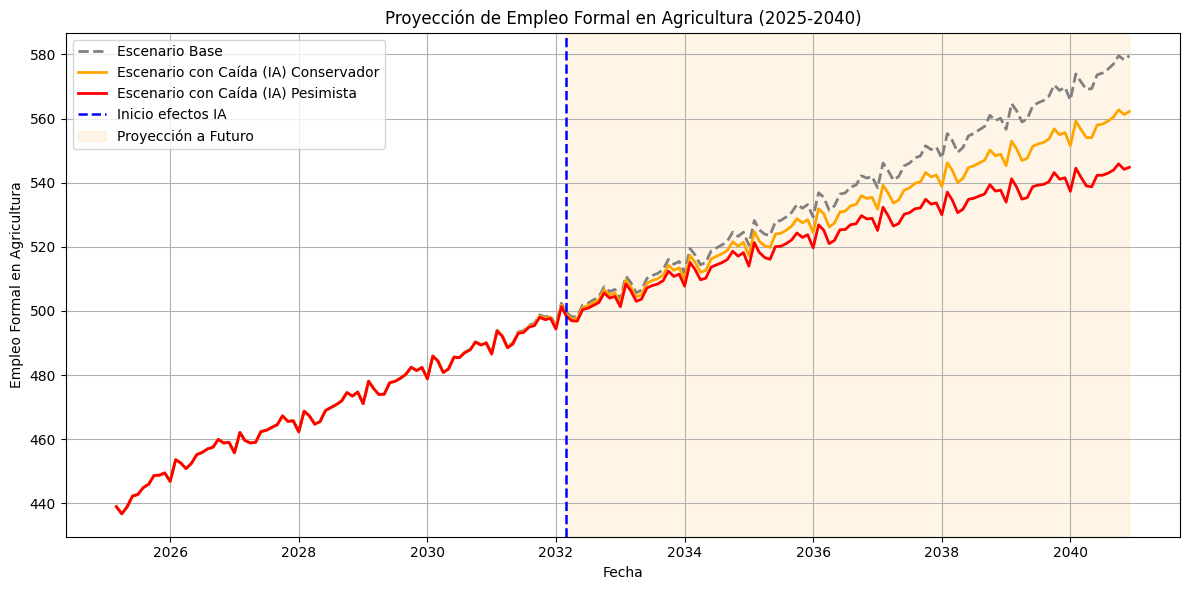

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['ds'], df['PredAgriculturaFormal'], 
            label='Escenario Base', color='gray', linestyle='--', linewidth=2)

plt.plot(df['ds'], df['PredAgriculturaFormalIAConservador'], 
            label='Escenario con Caída (IA) Conservador', color='orange', linewidth=2)

# Si tienes otro escenario de crecimiento, puedes añadirlo así:
if 'PredAgriculturaFormalIAPesimista' in df.columns:
    plt.plot(df['ds'], df['PredAgriculturaFormalIAPesimista'], 
                label='Escenario con Caída (IA) Pesimista', color='red', linewidth=2)

plt.axvline(x=pd.to_datetime("2032-03-01"), color='blue', linestyle='--', linewidth=1.8, label='Inicio efectos IA')
plt.axvspan(pd.to_datetime('2032-03-01'), pd.to_datetime('2040-12-01'), 
            color='navajowhite', alpha=0.3, label='Proyección a Futuro')

plt.xlabel('Fecha')
plt.ylabel('Empleo Formal en Agricultura')
plt.title('Proyección de Empleo Formal en Agricultura con Impacto IA (2025-2040)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Guardar si lo necesitas
# plt.savefig('proyeccion_agricultura.png', dpi=300)

plt.show()


# Forecast con ARIMAX

🔎 Diagnóstico de la serie original:
ADF Statistic: -5.9606
p-value: 0.0000
✅ La serie es estacionaria.


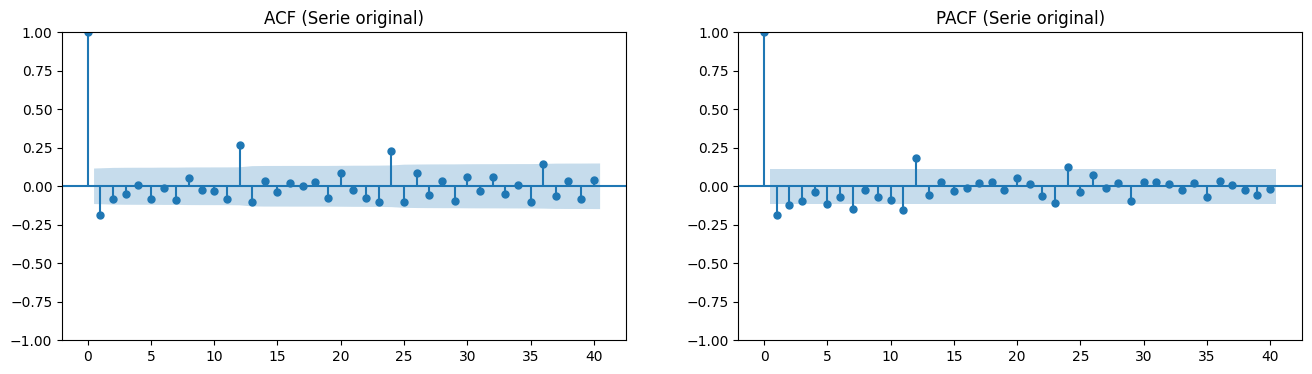

In [17]:
ts_diagnostics.full_ts_diagnostics(df['logdiff_fuerza de trabajo'])

# Entrenando Catboost

🔎 Diagnóstico de la serie original:
ADF Statistic: -5.3081
p-value: 0.0000
✅ La serie es estacionaria.


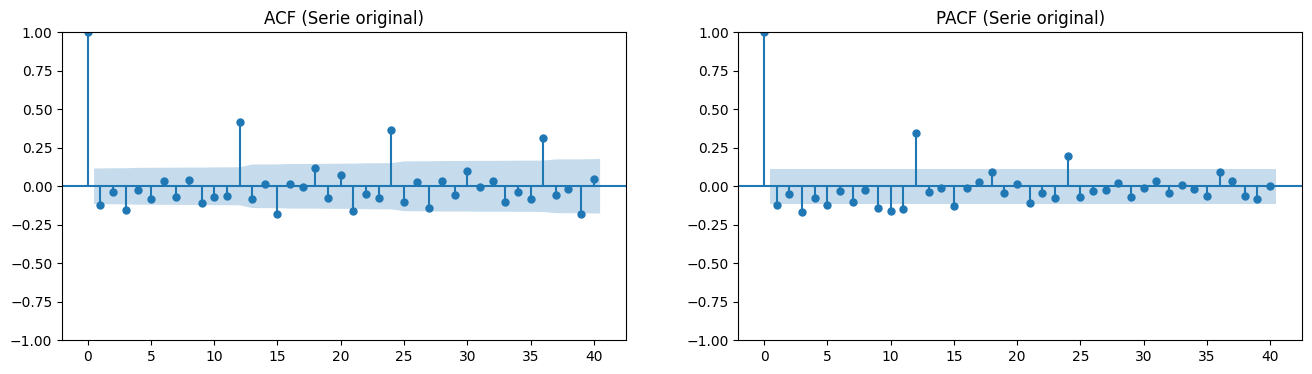

In [9]:
from src.epl_proyection.utils import ts_diagnostics
ts_diagnostics.full_ts_diagnostics(df_labor['logdiff_población ocupada'])

In [10]:
from src.epl_proyection.models.catboost.catboost_main_pipeline import run_catboost_pipeline

# Correr todo el pipeline
df_final = run_catboost_pipeline(df_labor_new, n_trials = 30)

[I 2025-04-28 20:03:51,643] A new study created in memory with name: no-name-c417e083-cef5-43ff-9a27-1cd5f33d1cab
[I 2025-04-28 20:03:52,864] Trial 0 finished with value: 0.06361470754858226 and parameters: {'iterations': 664, 'learning_rate': 0.05184935697745912, 'depth': 6, 'l2_leaf_reg': 3.4757077439487607, 'bagging_temperature': 0.150475852590103, 'random_strength': 0.37544639422613046}. Best is trial 0 with value: 0.06361470754858226.
[I 2025-04-28 20:03:54,529] Trial 1 finished with value: 0.0560110573229169 and parameters: {'iterations': 690, 'learning_rate': 0.018039867690173805, 'depth': 7, 'l2_leaf_reg': 0.19857385011197595, 'bagging_temperature': 0.8315111128681353, 'random_strength': 0.6439120583317782}. Best is trial 1 with value: 0.0560110573229169.
[I 2025-04-28 20:03:58,634] Trial 2 finished with value: 0.06718341715681875 and parameters: {'iterations': 943, 'learning_rate': 0.04662863994873101, 'depth': 8, 'l2_leaf_reg': 0.03606745672439267, 'bagging_temperature': 0.47

0:	learn: 0.0004804	total: 2.4ms	remaining: 1.77s
1:	learn: 0.0004710	total: 5.25ms	remaining: 1.94s
2:	learn: 0.0004658	total: 6.52ms	remaining: 1.6s
3:	learn: 0.0004620	total: 8.09ms	remaining: 1.49s
4:	learn: 0.0004360	total: 9.81ms	remaining: 1.44s
5:	learn: 0.0004126	total: 10.5ms	remaining: 1.29s
6:	learn: 0.0004052	total: 11.2ms	remaining: 1.17s
7:	learn: 0.0003840	total: 12.4ms	remaining: 1.14s
8:	learn: 0.0003637	total: 14.1ms	remaining: 1.14s
9:	learn: 0.0003582	total: 15.6ms	remaining: 1.14s
10:	learn: 0.0003401	total: 16.3ms	remaining: 1.08s
11:	learn: 0.0003377	total: 16.9ms	remaining: 1.02s
12:	learn: 0.0003207	total: 20.1ms	remaining: 1.12s
13:	learn: 0.0003147	total: 21ms	remaining: 1.09s
14:	learn: 0.0003123	total: 21.7ms	remaining: 1.05s
15:	learn: 0.0003104	total: 22.3ms	remaining: 1.01s
16:	learn: 0.0002954	total: 23.4ms	remaining: 994ms
17:	learn: 0.0002934	total: 24ms	remaining: 962ms
18:	learn: 0.0002864	total: 24.5ms	remaining: 931ms
19:	learn: 0.0002726	total: 

In [ ]:
df_final.rename(columns={'PredPea': 'PredPETArimax',
                        'pred_pea_catboost':'PredPETCatboost'}, inplace=True)

Index(['YearMonth', 'Year', 'Month', 'workdays', 'weekends', 'holidays',
       'Población en edad de trabajar (PET)', 'Población ocupada',
       'Agricultura, ganadería, caza, silvicultura y pesca',
       'Industrias manufactureras', 'Formal', 'Informal', 'MonthNumber',
       'log_población en edad de trabajar (pet)',
       'logdiff_población en edad de trabajar (pet)', 'log_población ocupada',
       'logdiff_población ocupada',
       'log_agricultura, ganadería, caza, silvicultura y pesca',
       'logdiff_agricultura, ganadería, caza, silvicultura y pesca',
       'log_industrias manufactureras', 'logdiff_industrias manufactureras',
       'log_formal', 'logdiff_formal', 'log_informal', 'logdiff_informal',
       'negative_crashes', 'CommentBinaryVariable', 'proportion_formal_PET',
       'proportion_informal_PET', 'porportion_aggriculture_Occupied',
       'proportion_manufacturing_Occupied', 'ds', 'proportion_formal_PET_ma24',
       'proportion_informal_PET_ma24', 'porporti